# `qfit` Quick Start

Tianpu Zhao, Danyang Chen and Jens Koch

This guide will walk you through the basic usage of `qfit` and its features. We have prepared a simple task for you to practice fitting with `qfit`. Don't worry, this guide provides detailed steps for you to follow. 

## Background & your task

You are given a **superconducting circuit** composed of a fluxonium qubit and a resonator mode. They are capacitively coupled. The effective circuit is shown below:
<p align="center">
  <img width="300" src="../resources/images/example_circuit.png">
</p>  

This circuit is described by the following **Hamiltonian**:
$$
H = H_{\rm res} + H_{\rm qubit} + H_{\rm int}
$$
with the resonator and qubit Hamiltonians and their interactions given by
\begin{align*}
H_{\rm res} &= E_{\rm osc} a^\dagger a \\
H_{\rm qubit} &= 4E_C n^2 - E_J \cos(\varphi+2\pi\Phi_{\rm ext}/\Phi_0) + \frac{1}{2}E_L\varphi^2 \\
H_{\rm int} &= g(a+a^\dagger) n
\end{align*}
where $a$ is the annihilation operator of the resonator, $n$ ($\varphi$) is the number (phase) operator of the qubit. $\Phi_{\rm ext}$ is the external flux, and $\Phi_0$ is the flux quantum.  Circuit parameters and their estimates (typically obtained from EM simulations and the Ambegaokar–Baratoff relation) are listed below:

| Parameter | Symbol | Rough Estimate ($\textrm{GHz}\times h$) | Uncertainty ($\textrm{GHz}\times h$) |
| --- | --- | --- | --- |
| Josephson Energy | $E_J$ | $3.2$ | $\pm 0.5$ |
| Charging Energy | $E_C$ | $0.95$ | $\pm 0.07$ |
| Inductive Energy | $E_L$ | $0.23$ | $\pm 0.05$ |
| Coupling Strength | $g$ | $0.106$ | $\pm 0.08$ |
| Resonator frequency | $E_{\mathrm{osc}}$ | $6.035$ | $\pm 0.06$ |

To determine the qubit parameters ($E_J$, $E_C$ and $E_L$), one can perform a **two-tone spectroscopy experiment**. It's summarized in the image below:
<figure align="center">
  <img width="700" src="../resources/images/example_two_tone_setup.png">
</figure>  

In the experiment, two tones of RF drive are applied to the system - a tone with frequency $f$ to the qubit and a tone near frequency $E_{\rm osc} / h$ to the resonator. One then measure the transmission or reflection of the RF signal through the resonator. If the qubit drive pulse frequency $f$ happens to match a transition frequency of the qubit-resonator system, then the pulse may drive this transition. This may introduce a shift on the resonator frequency, which changes the amplitude and phase of the transmission/reflection signal. By performing such measurement for different $f$ and $\Phi_{\rm ext}$, one can obtain obtain the spectroscopy dataset.

Check out below for an example of such dataset:

Below is the information of the dataset and the shape of elements:
freq (2543,)
mags (81, 2543)
voltage (81,)


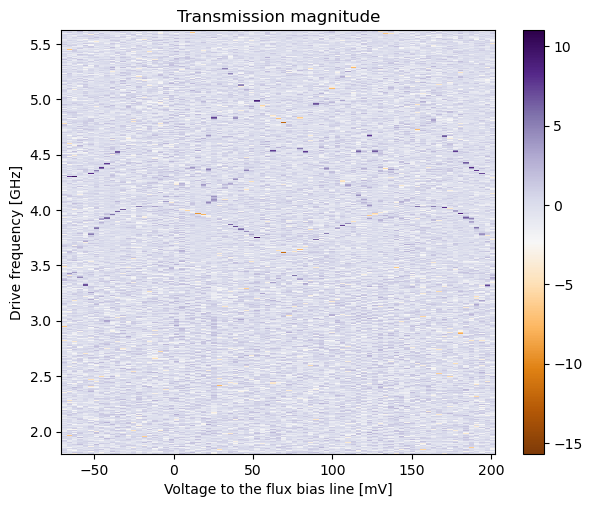

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset in the h5 file (you don't need to do this while using QFit)
print("Below is the information of the dataset and the shape of elements:")
with h5py.File("../example_data/joint_qubit_twotone.h5", "r") as file:
    # Print the information of the dataset
    def print_info(name, obj):
        print(name, obj.shape)
    file.visititems(print_info)

    # store the dataset in those variables
    dataset = np.array(file["mags"])
    omega, voltage = np.meshgrid(file["freq"], file["voltage"], indexing="ij")

# Plot the dataset
plt.figure(figsize=(7, 5.5))
plt.pcolormesh(voltage, omega, dataset.T, cmap="PuOr", rasterized=True)
plt.colorbar()
plt.xlabel("Voltage to the flux bias line [mV]")
plt.ylabel("Drive frequency [GHz]")
plt.title("Transmission magnitude")
plt.show()

In the dataset, the peaks (appears as dark purple/dark yellow spots) represent resonances between the $f$ and the transition frequencies. Since our goal is to determine the qubit parameters, the sampling range of $f$ does not include the resonator frequency (which is 6.035 GHz). **Your task is to fit the dataset and extract the parameters.** - This is where `qfit` comes in. 

## Step 0: Build a numerical model and run `qfit`

We have helped you to create a numerical model of the quantum system using `scqubits.HilbertSpace`. To see the usage of `scqubits` in detail, please refer to the [scqubits documentation](https://scqubits.readthedocs.io/en/latest/).

In [1]:
import scqubits as scq

fluxonium = scq.Fluxonium(
    EJ = 3.0,
    EC = 0.9,
    EL = 0.25,
    flux = 0.5,
    cutoff = 100,
    truncated_dim = 5,
    id_str = "Fluxonium"
)
resonator = scq.Oscillator(
    E_osc = 6.035,
    l_osc = 1.0,
    truncated_dim = 4,
    id_str = "Resonator"
)

hilbert_space = scq.HilbertSpace([fluxonium, resonator])

hilbert_space.add_interaction(
    g = 0.106,
    op1 = fluxonium.n_operator,
    op2 = resonator.annihilation_operator,
    add_hc = True,
    id_str = "res-qubit"
)

**Reminder**

Notice that here we must use the callable version of the operators 1 and 2, so that matrices are properly updated when parameters are changed. For details, please see the caution in the following [scqubits documentation page on parameter sweep](https://scqubits.readthedocs.io/en/latest/guide/parametersweep/ipynb/paramsweep2.html#:~:text=Caution:%20When%20specifying,with%20fixed%20matrices).

#### Provide experimental dataset and launch `qfit`

Open the app using `Fit(<HilbertSpace>, <dataset file path>)`. An app (the graphical user interface, GUI) will pop up and we'll guide you through the GUI in the next few subsections. You may treat the following sections as a documentation and refer to it if necessary. Also you may click on the ? buttons for help.

In [2]:
from qfit import Fit

file_path = "../example_data/joint_qubit_twotone.h5"
fit = Fit(hilbert_space, file_path)

qt.qpa.fonts: Populating font family aliases took 134 ms. Replace uses of missing font family "Roboto Medium" with one that exists to avoid this cost. 


2025-07-16 15:17:39.186 python[32861:27302386] error messaging the mach port for IMKCFRunLoopWakeUpReliable


#### An overview of the GUI
After launching the GUI, you will see a window shown below. The window is divided into parts as shown here. 
<p align="center">
  <img width="600" src="../resources/images/example_GUI_overview.png">
</p>  

The fitting task is divided into 5 steps and you can navigate through them using the navigation menu: **Import**, **Calibrate**, **Extract**, **Pre-Fit** and **Fit**. Let's go through them one by one and you may perform the corresponding task as you read along.

## Step 1: Import dataset

Once the file is imported, `QFit` parses what is contained in the dataset file. Under <span style="color:rgb(190, 130, 250);">METADATA</span>, you may find the metadata of the imported file. What remains to be completed by you is to <span style="color:rgb(190, 130, 250);">SELECT AXES</span> and thereby adjust orientation of the figure, using the panel below.
<p align="center">
  <img width="300" src="../resources/images/example_axes_select.png">
</p> 

Once you select the desired x- and y-axis, the figure will be oriented correctly. And you can proceed to the next step by clicking "Proceed to calibrate" button.

## Step 2: Calibrate

#### The calibration process

In this step, we aim to
1. map the **x-axis** of measurement dataset to the circuit parameter. In our case, we want to map the flux bias line voltage in mV the external flux in $\Phi_0$. The same principle can also apply to circuits that are tuned by offset charges.
2. map the **y-axis** of measurement dataset to frequencies **in unit of GHz**, which is `scqubit`'s default unit.

`QFit` assumes a linear relationship between the flux bias line voltage ($x$) and external flux ($x'$), i.e. $x' = ax + b$. In this case, two pairs of $(x, x')$ values to determine the map, as shown below.
<p align="center">
    <img width="350" src="../resources/images/calibration_notebook_ver.png">
</p>  


#### Calibration in `qfit`: 
1. Click the "EXTRACT RAW" button. It activates the extraction for $x_1$. 
2. In the plot, identify/guess a zero-flux point and click. The $x_1$ coordinate will be automatically extracted.  
3. Enter the value $x_1^\prime$, which is 0.0 flux quantum.  
4. Repeat the above steps for $x_2$.  
    
You can also check out the video below for a quick demonstration.

<div style="text-align: center;">
  <video src="../resources/videos/calibration.mp4" width="500" controls>
    [Your browser does not support the video tag.]
  </video>
</div>

Finally, you can re-plot and check the calibrated axes by clicking "View Calibrated Axes" on the top right corner.

**Tips**

For a fluxonium, the Hamiltonian is periodic in flux with period $\Phi_0$ and symmetric around $\Phi_{\rm ext} = \frac{m}{2} \Phi_0$, where $m$ is an integer. Therefore, we can identify and map the x coordinates with those properties.

## Step 3: Extract

Now let's navigate to the next step and extract resonance peaks out of the spectroscopy dataset. In `QFit`, extracted data points are grouped by  <span style="color:rgb(190, 130, 250);">TRANSITIONS</span>. For example, there is a spectral line in the dataset which is believed to be the plasmon transition $|\overline{0_{\rm res},0_{\rm qubit}}\rangle \rightarrow|\overline{0_{\rm res},2_{\rm qubit}}\rangle$. Follow these steps to extract and label these data points:

1. Select / create a group of transition data points and label it. In this case, we uses bare state label $(0, 0) \to (0, 2)$:
<p align="center">
    <img width="200" src="../resources/images/example_transition_n_label.png">
</p>  
   
2. Click on the canvas near a peak to select it. There a few helpful tools for you in this step (see tips below). Here is how it looks.
<p align="center">
    <img width="250" src="../resources/images/example_extract02.png">
</p>  

3. If you want to increase the fitting accuracy, extract more transitions as shown below by repeating step 1, 2.
<p align="center">
    <img width="250" src="../resources/images/example_transitions.png">
</p>  

**Tips**

To assist you in the data point extraction, the following button will be useful when playing with the canvas.
<p align="center">
    <img width="500" src="../resources/images/example_MPL_buttons.png">
</p>  

They are (from left to right): **Reset | Pan, Zoom, Extract | X-Snap, Y-Snap | View Calibrated Axes**. 

1. **Pan**, **Zoom** and **Extract** buttons controls the usage of the cursor.
2. **X-Snap** button helps to align the x-coordinate among different transitions (groups). This tool help you align extracted data points along the same flux points; by selecting fewer distinct flux points, it speeds up calculations for transition frequencies.

<div style="display: flex; justify-content: center; align-items: center;">
    <img width="200" src="../resources/gifs/X_snap.gif">
    <div style="width: 50px;"></div>  <!-- Spacer -->
    <img width="223" src="../resources/images/example_same_x_preferred.png">
</div>

3. And the **Y-Snap** button assists you to locate the peak precisely.
<p align="center">
    <img width="200" src="../resources/gifs/Y_snap.gif">
</p>

4. To **delete points**, select the corresponding transition and click on the vicinity of the extracted point.


## Step 4: Pre-Fit

After getting enough data points, we now start to fit by eye, aiming to find a good initial guess for the numerical fitting. In this step, you may play with **sliders** to make the numerical spectrum match the data points. During prefit, the numerical spectrum will be calculated and plotted on top of the measurement dataset. Besides, status bar will be updated with current Mean Squared Error (MSE), indicating how close the fit is.

<p align="center">
    <img height="20" src="../resources/images/example_prefit_status.png">
</p>

You may also fine-tune your calibration by adjusting the corresponding sliders, which controls the value that the raw axes are mapped to.

During pre-fitting, you may find out that changing the resonator frequency and the coupling strength within their uncertainty ranges does not affect the spectrum a lot. This is because the resonator and qubit are dispersively coupled. It signifies that our two-tone spectroscopy data are not sufficient to help us determine these two parameters, and data from a **single-tone spectroscopy experiment** are needed, which directly probes the resonator frequency. QFit support fitting to data from multiple experiments simutaneously, which is introduced in Section 1 of [QFit_Advanced_Tips.ipynb](./QFit_Advanced_Tips.ipynb)

After getting a good set of parameters, you will click **Result To Fit** button on the bottom left to copy the parameters to the <span style="color:rgb(190, 130, 250);">FIT</span> panel.

## Step 5: Fit
Finally, we are ready to fit the data points numerically! The main thing you need to do is configure the fitting parameters in the **FIT table**. You may adjust the following entries in the table:
- Whether to **Fix** or free a parameter during fitting
- The **Initial** guesses (from pre-fit)
- **Min** and **Max** values  

Due to the reason we mentioned before, we **fix** E_osc = 6.035 and g1=0.106 (both in $\textrm{GHz}\times h$), which are parameters when they are designed. 

Now click **Run Fit** and wait for the fitting to finish. 

If there is not warning or error message, congratulations! You have successfully fit the data points and the fit parameters can be found in **Current** column. 

If you want to make use of the fitting result as a initial guess, and repeat the numerical fitting with different configurations, you may click **Result To Initial**. In addition, clicking **Result To Prefit** will send the fit result to the <span style="color:rgb(190, 130, 250);">PRE-FIT</span> panel.

## Save, load and export
You may save / load the fitting session by clicking the <img width="20" src="../resources/images/example_menu.png"> button on the top left. The session will be saved as a `.qfit` file.

You can also open a new window to load the previous session.

In [1]:
from qfit import Fit
# this is an example file we already prepared for you
# If you didn't close the previous window, you'll get another one
fit = Fit.open("../example_data/QFit_Quick_Start.qfit")

qt.qpa.fonts: Populating font family aliases took 107 ms. Replace uses of missing font family "Roboto Medium" with one that exists to avoid this cost. 


Another option to continue working in the notebook is to retrieve objects from the fitting session to the jupyter notebook, and continue working on them. In these retrieval functions, the argument `source` is used to specify the source of retrieved parameters, the options are "fit" and "prefit". For the calibration result, an additional option "calibration" is also available, though the calibration parameters in the prefit stage and the calibration stage are the same.

**To get the HilbertSpace object**

In [3]:
fit_hilbertspace = fit.get_hilbertspace(deepcopy=True, source="fit")
fit_hilbertspace

HilbertSpace(**{'subsystem_list': [Fluxonium(**{'EJ': np.float64(3.363642382010571), 'EC': np.float64(0.974268757020912), 'EL': np.float64(0.20161762778368614), 'flux': np.float64(0.9760188943632216), 'cutoff': 100, 'truncated_dim': 5, 'id_str': 'Fluxonium', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None}), Oscillator(**{'E_osc': 6.035, 'l_osc': 1.0, 'truncated_dim': 4, 'id_str': 'Resonator'})], 'interaction_list': [InteractionTerm(**{'g_strength': 0.106, 'operator_list': [(0, array([[ 0.+0.j        , -0.-0.30523679j,  0.+0.j        , ...,
         0.+0.j        ,  0.+0.j        ,  0.+0.j        ],
       [ 0.+0.30523679j,  0.+0.j        , -0.-0.43167001j, ...,
         0.+0.j        ,  0.+0.j        ,  0.+0.j        ],
       [ 0.+0.j        ,  0.+0.43167001j,  0.+0.j        , ...,
         0.+0.j        ,  0.+0.j        ,  0.+0.j        ],
       ...,
       [ 0.+0.j        ,  0.+0.j        ,  0.+0.j        , ...,
         0.+0.j 

**To get the circuit parameters**

In [4]:
fit_parameters = fit.get_circuit_parameters(source="fit")
fit_parameters

{('Fluxonium', 'EJ'): np.float64(3.363642382010571),
 ('Fluxonium', 'EC'): np.float64(0.974268757020912),
 ('Fluxonium', 'EL'): np.float64(0.20161762778368614),
 ('Resonator', 'E_osc'): 6.035,
 ('Interactions', 'g1'): 0.106}

**To get the calibration result**

In [5]:
calib_result = fit.get_calibration_result(source="fit")
calib_result

FullCalibrationResult
--------------------------------
x-axis
raw to mapped: mapped_sweep_params = x_linear @ raw_dc_biases + x_offset
raw_dc_biases_names: voltage
mapped_sweep_params_names: ('Fluxonium', 'flux')
--------------------------------
x_linear =
[[0.003697]]
x_offset = [0.232929]
--------------------------------
y-axis
raw to mapped: mapped_y = y_slope * raw_y + y_offset
raw_y_name: freq
--------------------------------
y_slope = 1.0
y_offset = 0.0


The variable `calib_result` gathers various information about the calibration. For example, to get the mapped sweep parameter for a given set of raw parameters:

In [6]:
mapped_sweep_param_example = calib_result.get_mapped_sweep_params(
    raw_dc_biases={"voltage": 0.1}, return_dict=True,
)
print(
    "The mapped sweep parameter for a given set of raw parameters is:\n",
    mapped_sweep_param_example,
)

The mapped sweep parameter for a given set of raw parameters is:
 {('Fluxonium', 'flux'): 0.23329918913273157}


To get the coefficients of the transformation (`x_linear` and `x_offset`):

In [7]:
print(
    "The coefficients of the transformation are:\n",
    "x_linear: ", calib_result.x_linear, "\n",
    "x_offset: ", calib_result.x_offset, "\n",
)

The coefficients of the transformation are:
 x_linear:  [[0.00369696]] 
 x_offset:  [0.23292949] 



**To export extracted points**

In [8]:
extracted_points = fit.get_extracted_points()

The extracted points are stored in a dictionary-like object, the keys are the figure names

In [9]:
acceptable_keys = extracted_points.list_figures()
print("Acceptable keys (figure names):", acceptable_keys)

Acceptable keys (figure names): ['joint_qubit_twotone.h5']


For each figure, transitions are stored in a dictionary, the keys are the transition names

In [13]:
print(
    "Transitions in 'joint_qubit_twotone.h5':", 
    extracted_points.list_transitions("joint_qubit_twotone.h5")
)

Transitions in 'joint_qubit_twotone.h5': ['0 - 2', '0 - 1 (fluxon)', '0 - 3', '1 - 2', '1 - 3']


To retrieve extracted plasmon transitions in `joint_qubit_twotone.h5`

In [12]:
extracted_points["joint_qubit_twotone.h5"]["0 - 2"]

{'type': 'DISPERSIVE_BARE',
 'photons': 1,
 'initial_states': [(0, 0)],
 'final_states': [(2, 0)],
 'y': array([3.6225 , 3.78175, 3.92875, 3.892  , 3.75375, 3.97075, 3.63825,
        3.7345 , 3.85875, 4.02325, 3.934  , 3.84125, 3.976  ]),
 'x': {'voltage': array([-65.625, -52.125, -42.   ,  32.25 ,  52.5  ,  15.375,  66.   ,
          89.625, 106.5  , 170.625, 184.125, 190.875, 130.125])}}

## Final words
We hope you have enjoyed this tutorial and learned how to use `QFit`. There are a few advanved tips in `QFit_Advanced_Tips.ipynb`, please check out if you want to make full use of the package. 

If you have any questions, please feel free to contact us by:  
Tianpu Zhao: TianpuZhao2022@u.northwestern.edu  
Danyang Chen: DanyangChen2026@u.northwestern.edu